# Visualizing Data with UMAP

UMAP is a technique for embedding data into two dimensions in a manner that captures as much information about the high dimensional representation as possible. In practice this means that you can take complex high dimensional data and  compress it down to something that can be represented visually as a scatterplot. This makes it very valuable for exploratory data analysis -- just learning about, and gaining some intuition about your data. In this notebook we'll work through an example (on sample data) to demonstrate how to use UMAP to reduce the dimension, and how to use that to build an interactive plot to let your explore your data further.

## Embedding data

Our first goal is to use UMAP to embed data into two dimensions. To start with we will load the base libraries we might make use of: numpy for handling of numeric arrays, and pandas for working with data frames -- there are cheat sheets and other notebooks available to explain more about these libraries.

In [1]:
import numpy as np
import pandas as pd

For our test data we will use the sample of MNIST digits that is packaged into sklearn. We can access this from ``sklearn.datasets`` via the ``load_digits`` function.

In [2]:
from sklearn.datasets import load_digits

Finally we will need UMAP itself for embedding the data. Here we will make use of the UMAP implementation available in sklearn as the ``TSNE`` class.

In [3]:
from umap import UMAP

Let's get the data extracted, and have a look at it, so we know what the starting point for working with data is.

In [4]:
digits = load_digits()
data = digits.data
data

array([[  0.,   0.,   5., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,  10.,   0.,   0.],
       [  0.,   0.,   0., ...,  16.,   9.,   0.],
       ..., 
       [  0.,   0.,   1., ...,   6.,   0.,   0.],
       [  0.,   0.,   2., ...,  12.,   0.,   0.],
       [  0.,   0.,  10., ...,  12.,   1.,   0.]])

We have a large array of numbers. Each row is an observation -- a sequence of numeric values associated to a handwritten digit. Obviously it is hard to see what is going on here, and how these different vectors of numbers inter-relate. We would like to be able to visualise the full data set to get an undestanding of any underlying structure, whether there might be outliers, etc. Right now the data has dimensions as follows:

In [5]:
data.shape

(1797, 64)

So we have 1797 observations, and each one has 64 different features. This is high dimensional data, and difficult to visualise. One positive point is that it is all purely numeric data -- that is a prerequisite for UMAP. If your data isn't numeric (yet) you may wish to consult some of the other notebooks (or the data science support team) about how to get your data into more numeric form.

So next comes the difficult step of embedding the data into two dimensions. To start we'll use the ``TSNE`` class, instantiating it with default parameters, and use the ``fit_transform`` method to fit the model to the data.

In [6]:
embedding = UMAP().fit_transform(data)

And we are done. The data in ``embedding`` is a two dimensional representation of the original 64 dimensional data. Now we want to visualize it, ideally in a way that will let us explore the data further.

## Visualizing with Bokeh

We will be using the Bokeh library for plotting since it allows for interactive plots that can be zoomed, panned, and has support for hover tooltips so we can get extra information about individual data points. Bokeh is a very rich and powerful library, and can look a little complex and intimidating at first, however we can follow a basic recipe to get the results we want, and it will not be hard to alter the recipe to suit more specific needs. First we'll need to load various pieces from bokeh. The main thing to note here is the use of the ``output_nodebook`` function, which tells bokeh to plot directly in the notebook. Since we are on an airgapped network we also need to load the ``INLINE`` javascript resources, and pass that to output_notebook -- this stops bokeh from trying to access the relevant javascript from CDNs on the internet.

In [7]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.resources import INLINE

output_notebook(resources=INLINE)

Loading BokehJS ...

Bokeh works best with data frames, so we will put our data into a dataframe using pandas. This is simply a matter of creating the dataframe with ``embedding`` as the data and suitable column names. We will add an extra column to our dataframe called ``target`` and populate it with the ``target`` field of the digits dataset. This is the actual digit associated to each vector. We add this information so we can allow it to be visible in the hover tooltip.

In [8]:
plot_dataframe = pd.DataFrame(embedding, columns=('x', 'y'))
plot_dataframe['target'] = digits.target

Now we need to actually plot the data. This has a few steps which I will explain. First we create a bokeh ``ColumnDataSource`` using the dataframe we created. This allows bokeh to embed that data directly into the plot and have the interactive javascript end make use of it (for example, it allows the hover to access the target information).
Next we create a figure -- this is the plot area, and we give it a title and some default tools. Next we add a hovertool, and specifically tell it what the content of the tooltip should be; this is a list a pairs with a key, and the field of the datasource to look for the associated data to display. In our case we only have one piece of data to associate -- the actual digit, and it is in the ``target`` column (which we denote as being a column in the data source by prepending an ``@``). Finally it is time to add the data itself: we plot circles with data coming from the data source we created; x coordinates from the ``x`` column, y coordinates from the ``y`` column, and some styling parameters to make the circles slightly translucent allowing us to see overlapping circles better. With all that done we call ``show`` to display the plot.

The result is a visual representation of the digits data. Importantly it is interactive: we can zoom and pan around the data, and by hovering over circles we got a tooltip popping up telling us the target value of the data points we are hovering over. By hovering we can quickly see that the two dimensional representation has actually found the structure of the data well -- different digits fall close to one another, and interestingly there are subgroups of certain digits that show up in different parts of the space.

In [9]:
plot_datasource = ColumnDataSource(plot_dataframe)

plot_figure = figure(title='UMAP embedding of the MNIST digits data',
                     plot_width=600,
                     plot_height=600,
                     tools=('pan, wheel_zoom, box_zoom, resize, reset'),
                     active_scroll='wheel_zoom')

plot_figure.add_tools( HoverTool(tooltips = [('digit', '@target')]))

plot_figure.circle('x', 'y', source=plot_datasource, line_alpha=0.8, fill_alpha=0.8, size=2)

show(plot_figure)

This is quite nice, and let's us explore the data (and we could potentially have the tooltip display whatever data about the data points you wish -- simply add columns to the dataframe and key columnname pairs to the tooltipo creation). In practice bokeh is even more powerful than that. While no singl enotebook can do it justice, we'll pursue some approaches to enhancing the plot below to demonstrate some of what can be done.

First we'll need a few extra libraries -- these are mostly for extra propcessing specific to our digits dataset, so don't concern yourself too much with the details. It turns out that the vector of 64 numbers is *actually* the 64 entries of an 8x8 grayscale pixel representation of the handwritten digit. What we would like to do is somehow include that *image* in the tooltip so we can actually see the different writing styles of different points.

To do that we have to do a little data massaging -- we need to actually generate images. The details here aren't that important, but we are creating a base64 encoded representation of a PNG rendering of the 8x8 pixel representation.

In [10]:
from scipy.misc import toimage
from io import BytesIO
import base64
import PIL
import hdbscan

In [11]:
def embeddable_image(data):
    img = toimage(data).resize((64, 64), PIL.Image.BICUBIC)
    buffer = BytesIO()
    img.save(buffer, format='PNG')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,'  + base64.b64encode(for_encoding).decode()

We can then create a new column in the dataframe and add the base64 encoded images as the values in that column -- this will allow bokeh to access the images.

In [12]:
plot_dataframe['image'] = list(map(embeddable_image, digits.images))

As an added bonus we will cluster the embedded data so we can colour the circles according to cluster membership.

In [13]:
plot_dataframe['cluster'] = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=20).fit_predict(embedding)

Now we plot the data again, much as before, but we add in coloring of the circles by cluster, and now write a custom HTML tooltip that includes the base64 encoded image in it. This will allow us to mouseover and see images of the digits. This allows us to verify our suspicions -- the different groups of a given digit are a result of different writing styles. For example, do you cross your sevens or not? You end up a different part of the space depending.

In [14]:
from bokeh.models import CategoricalColorMapper
from bokeh.palettes import viridis


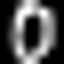
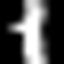
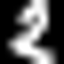
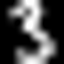
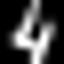
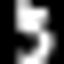
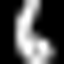
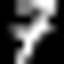
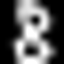
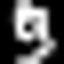
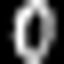
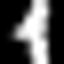
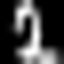
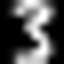
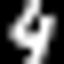
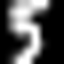
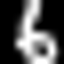
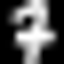
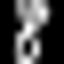
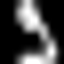
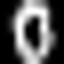
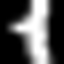
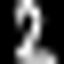
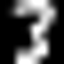
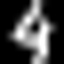
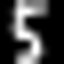
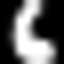
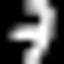
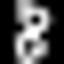
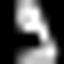
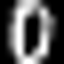
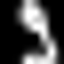
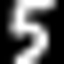
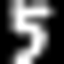
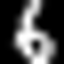
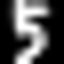
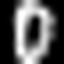
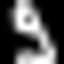
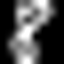
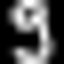
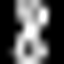
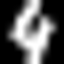
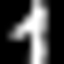
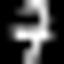
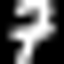
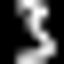
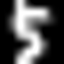
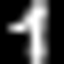
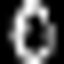
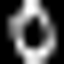
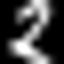
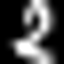
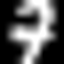
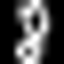
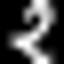
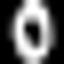
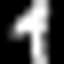
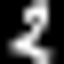
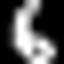
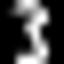
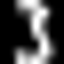
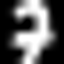
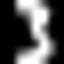
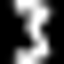
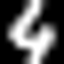
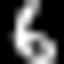
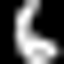
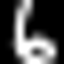
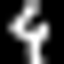
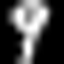
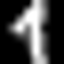
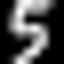
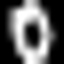
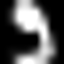
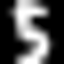
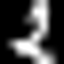
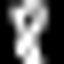
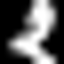
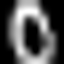
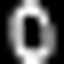
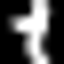
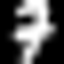
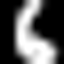
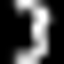
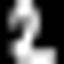
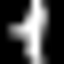
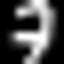
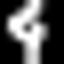
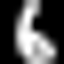
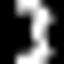
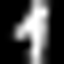
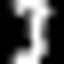
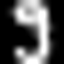
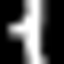
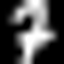
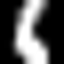
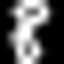
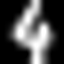
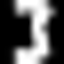
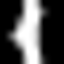
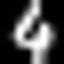
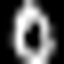
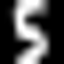
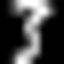
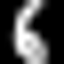
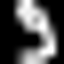
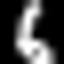
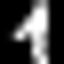
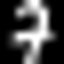
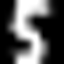
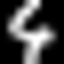
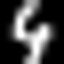
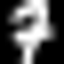
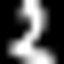
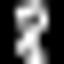
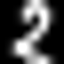
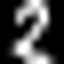
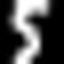
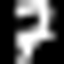
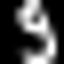
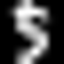
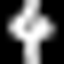
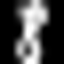
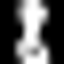
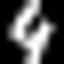
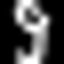
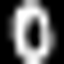
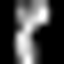
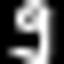
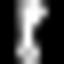
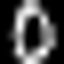
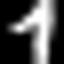
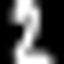
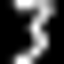
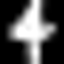
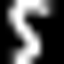
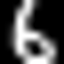
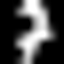
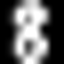
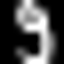
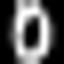
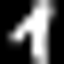
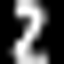
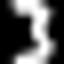
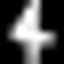
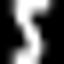
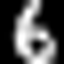
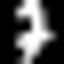
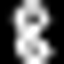
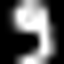
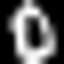
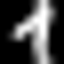
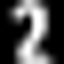
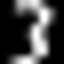
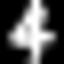
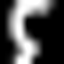
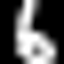
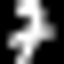
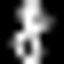
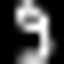
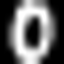
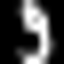
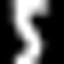
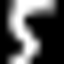
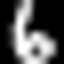
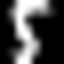
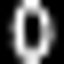
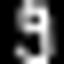
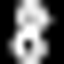
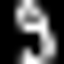
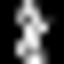
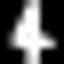
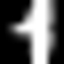
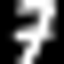
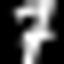
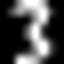
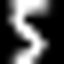
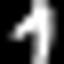
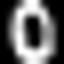
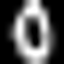
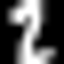
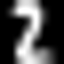
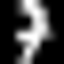
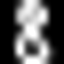
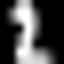
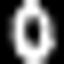
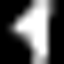
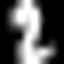
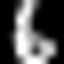
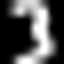
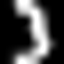
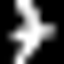
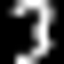
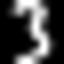
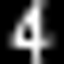
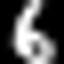
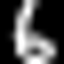
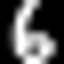
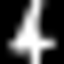
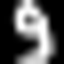
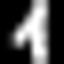
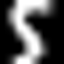
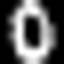
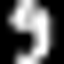
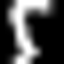
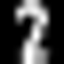
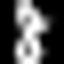
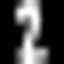
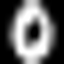
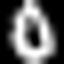
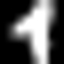
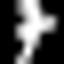
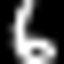
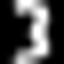
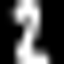
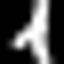
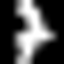
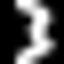
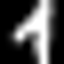
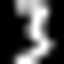
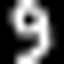
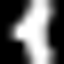
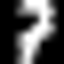
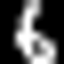
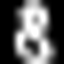
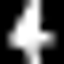
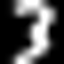
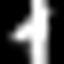
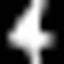
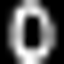
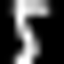
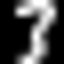
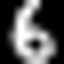
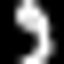
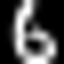
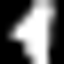
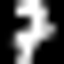
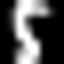
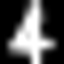
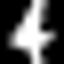
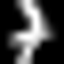
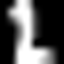
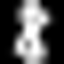
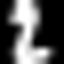
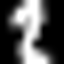
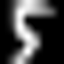
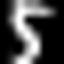
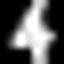
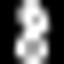
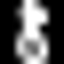
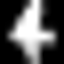
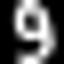
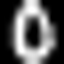
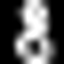
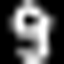
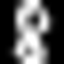
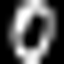
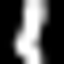
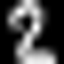
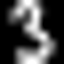
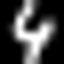
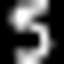
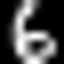
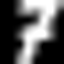
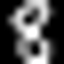
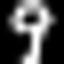
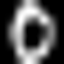
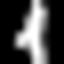
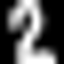
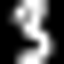
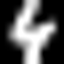
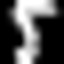
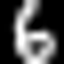
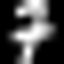
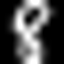
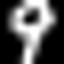
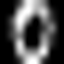
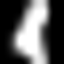
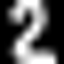
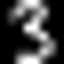
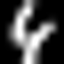
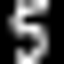
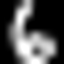
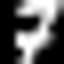
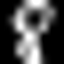
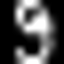
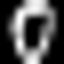
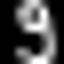
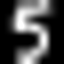
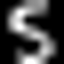
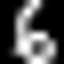
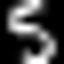
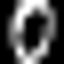
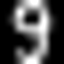
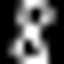
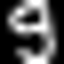
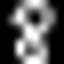
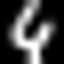
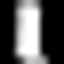
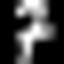
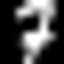
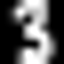
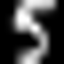
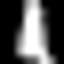
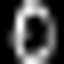
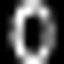
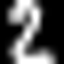
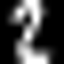
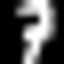
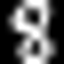
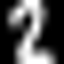
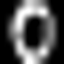
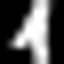
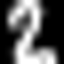
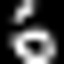
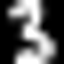
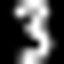
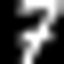
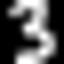
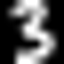
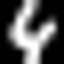
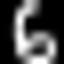
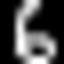
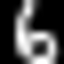
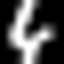
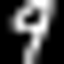
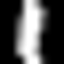
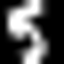
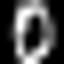
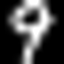
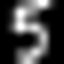
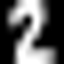
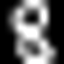
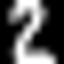
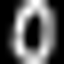
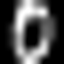
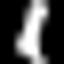
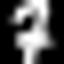
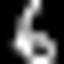
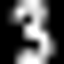
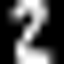
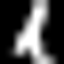
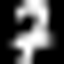
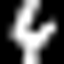
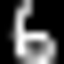
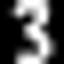
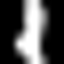
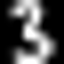
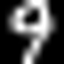
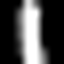
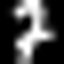
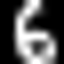
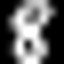
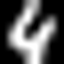
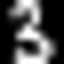
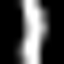
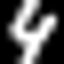
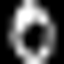
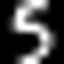
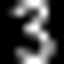
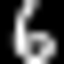
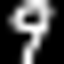
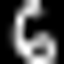
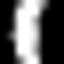
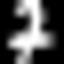
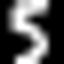
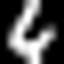
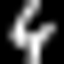
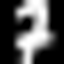
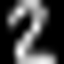
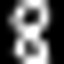
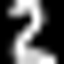
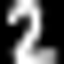
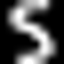
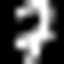
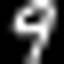
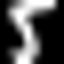
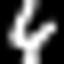
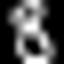
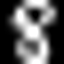
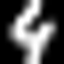
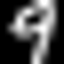
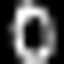
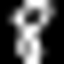
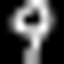
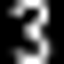
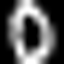
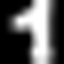
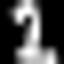
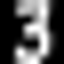
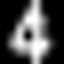
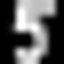
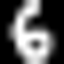
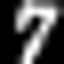
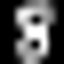
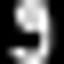
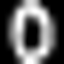
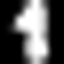
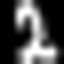
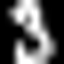
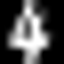
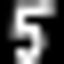
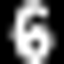
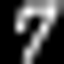
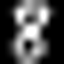
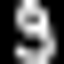
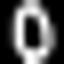
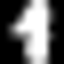
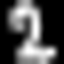
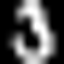
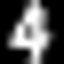
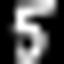
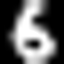
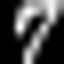
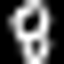
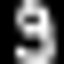
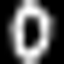
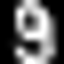
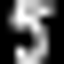
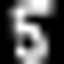
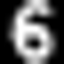
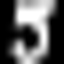
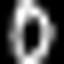
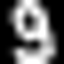
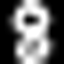
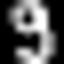
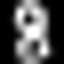
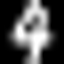
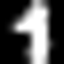
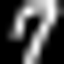
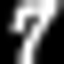
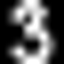
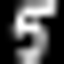
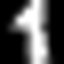
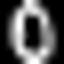
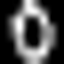
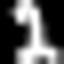
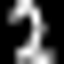
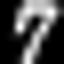
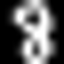
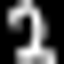
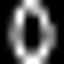
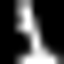
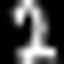
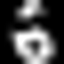
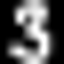
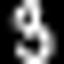
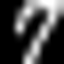
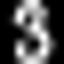
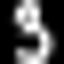
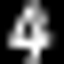
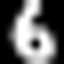
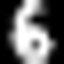
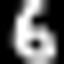
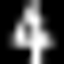
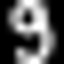
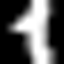
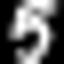
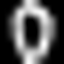
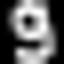
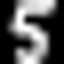
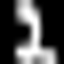
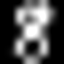
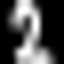
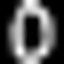
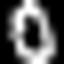
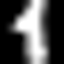
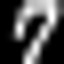
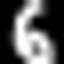
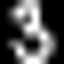
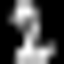
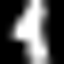
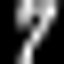
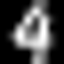
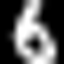
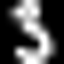
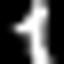
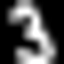
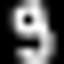
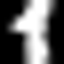
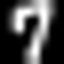
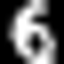
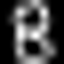
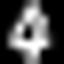
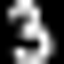
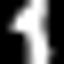
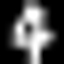
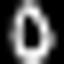
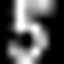
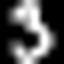
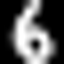
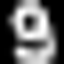
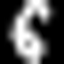
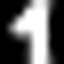
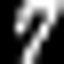
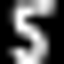
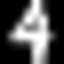
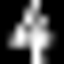
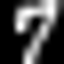
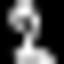
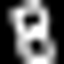
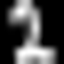
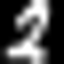
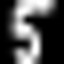
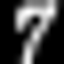
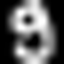
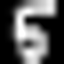
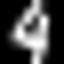
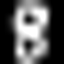
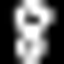
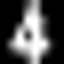
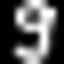
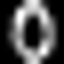
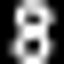
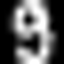
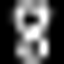
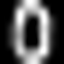
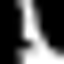
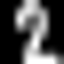
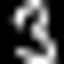
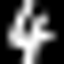
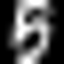
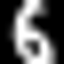
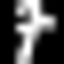
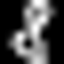
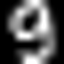
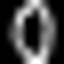
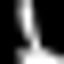
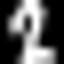
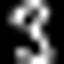
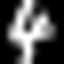
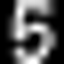
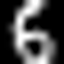
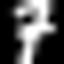
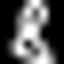
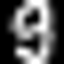
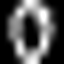
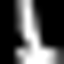
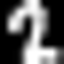
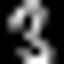
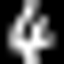
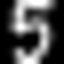
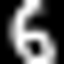
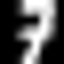
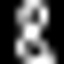
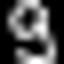
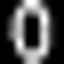
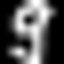
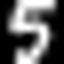
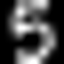
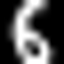
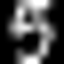
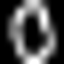
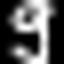
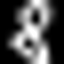
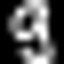
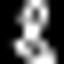
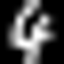
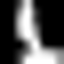
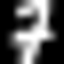
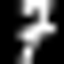
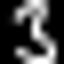
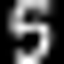
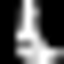
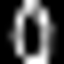
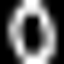
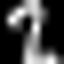
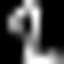
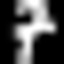
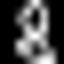
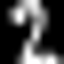
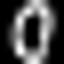
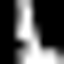
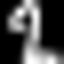
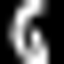
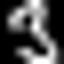
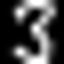
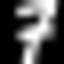
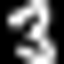
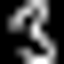
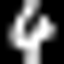
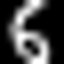
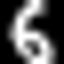
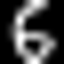
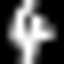
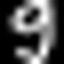
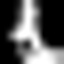
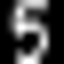
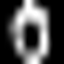
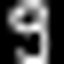
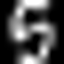
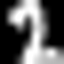
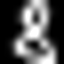
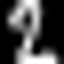
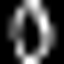
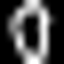
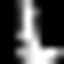
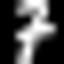
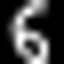
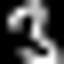
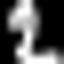
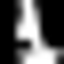
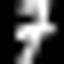
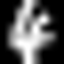
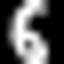
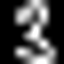
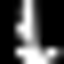
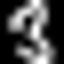
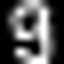
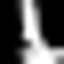
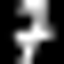
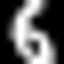
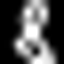
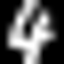
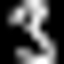
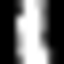
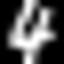
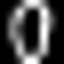
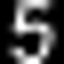
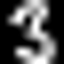
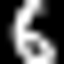
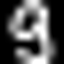
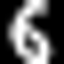
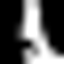
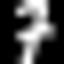
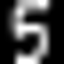
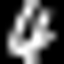
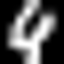
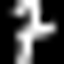
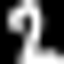
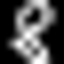
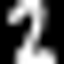
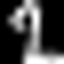
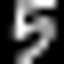
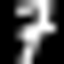
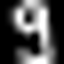
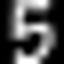
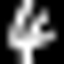
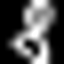
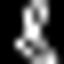
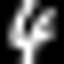
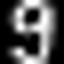
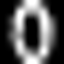
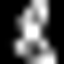
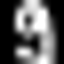
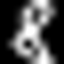
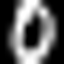
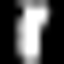
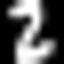
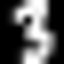
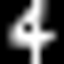
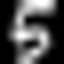
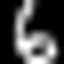
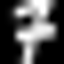
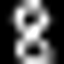
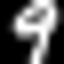
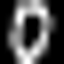
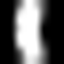
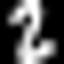
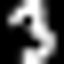
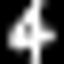
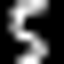
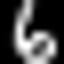
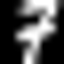
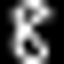
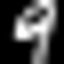
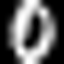
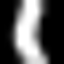
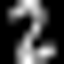
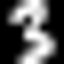
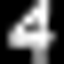
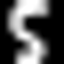
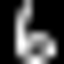
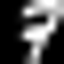
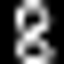
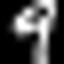
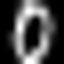
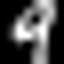
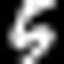
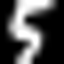
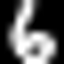
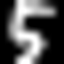
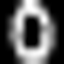
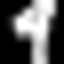
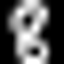
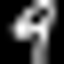
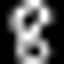
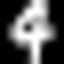
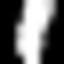
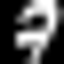
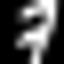
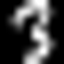
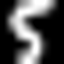
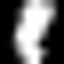
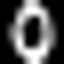
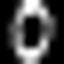
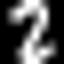
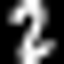
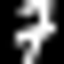
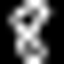
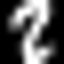
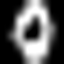
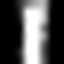
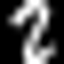
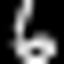
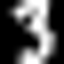
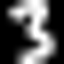
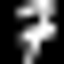
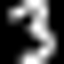
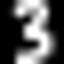
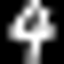
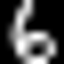
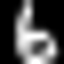
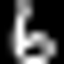
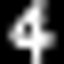
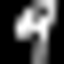
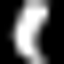
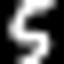
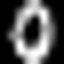
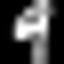
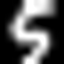
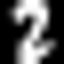
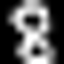
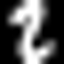
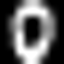
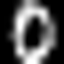
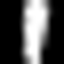
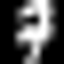
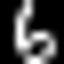
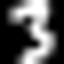
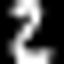
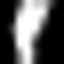
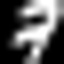
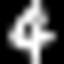
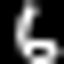
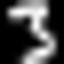
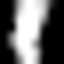
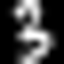
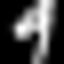
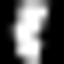
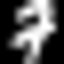
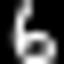
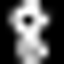
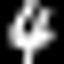
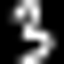
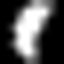
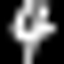
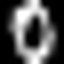
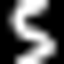
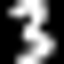
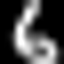
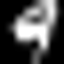
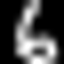
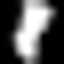
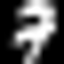
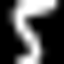
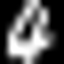
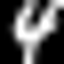
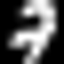
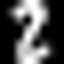
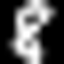
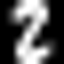
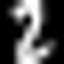
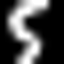
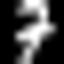
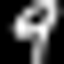
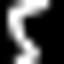
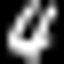
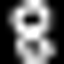
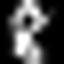
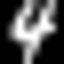
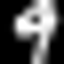
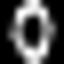
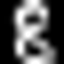
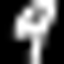
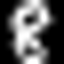
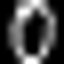
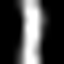
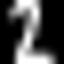
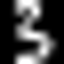
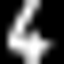
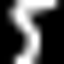
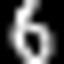
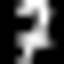
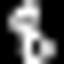
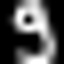
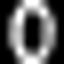
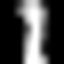
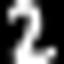
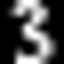
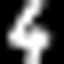
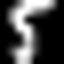
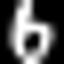
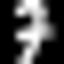
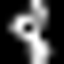
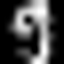
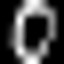
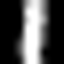
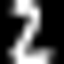
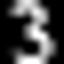
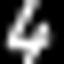
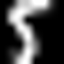
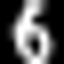
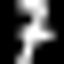
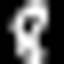
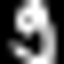
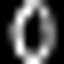
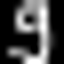
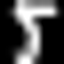
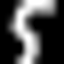
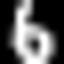
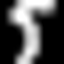
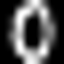
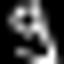
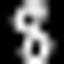
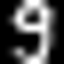
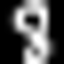
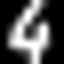
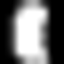
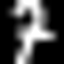
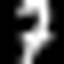
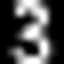
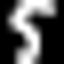
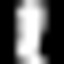
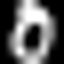
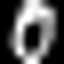
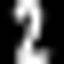
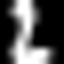
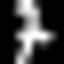
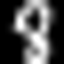
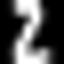
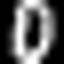
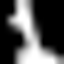
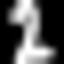
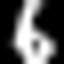
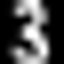
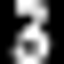
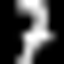
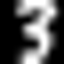
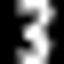
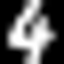
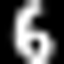
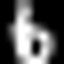
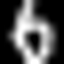
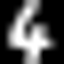
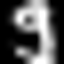
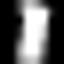
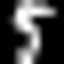
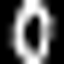
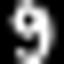
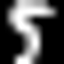
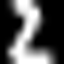
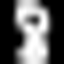
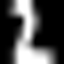
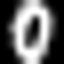
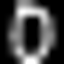
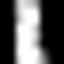
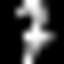
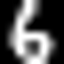
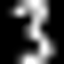
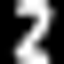
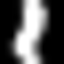
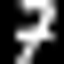
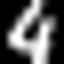
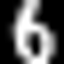
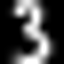
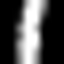
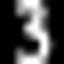
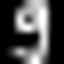
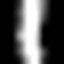
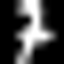
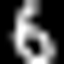
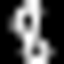
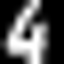
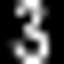
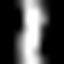
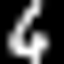
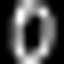
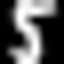
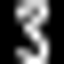
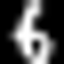
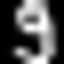
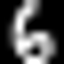
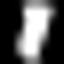
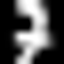
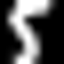
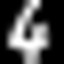
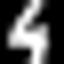
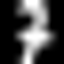
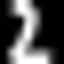
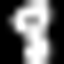
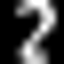
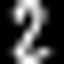
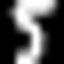
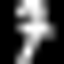
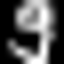
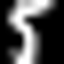
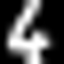
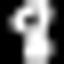
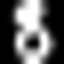
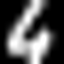
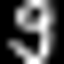
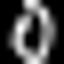
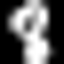
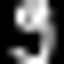
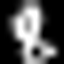
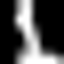
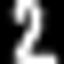
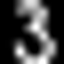
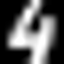
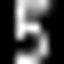
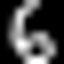
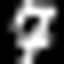
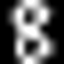
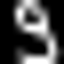
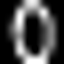
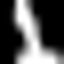
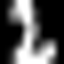
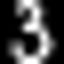
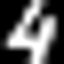
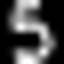
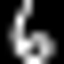
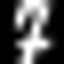
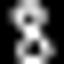
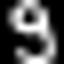
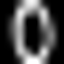
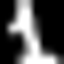
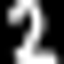
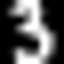
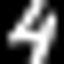
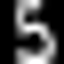
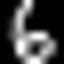
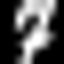
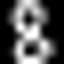
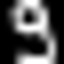
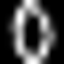
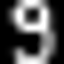
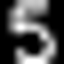
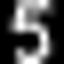
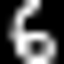
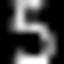
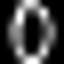
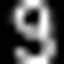
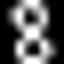
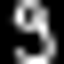
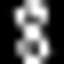
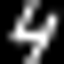
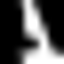
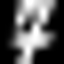
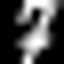
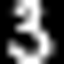
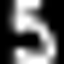
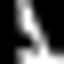
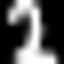
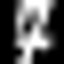
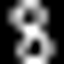
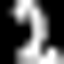
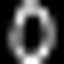
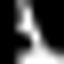
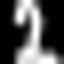
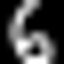
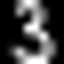
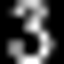
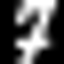
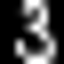
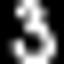
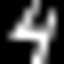
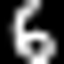
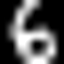
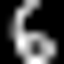
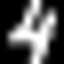
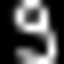
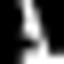
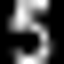
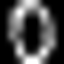
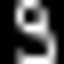
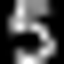
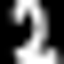
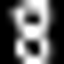
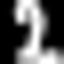
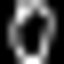
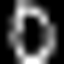
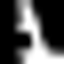
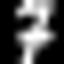
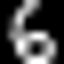
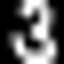
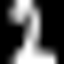
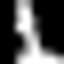
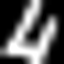
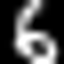
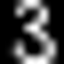
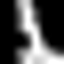
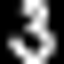
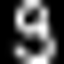
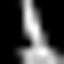
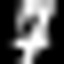
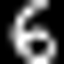
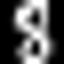
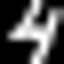
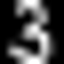
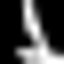
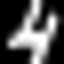
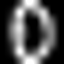
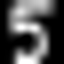
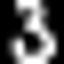
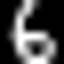
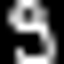
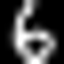
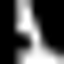
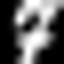
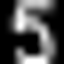
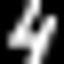
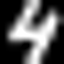
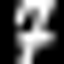
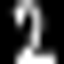
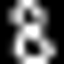
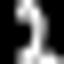
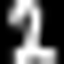
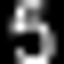
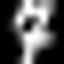
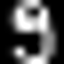
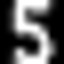
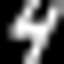
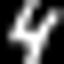
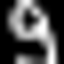
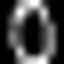
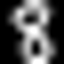
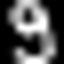
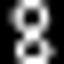
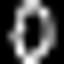
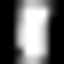
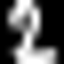
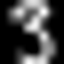
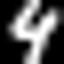
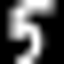
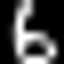
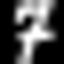
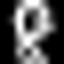
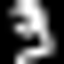
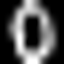
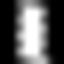
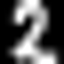
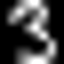
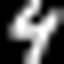
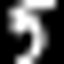
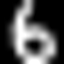
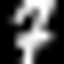
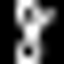
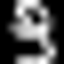
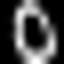
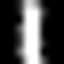
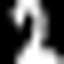
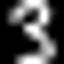
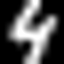
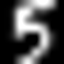
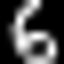
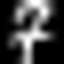
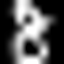
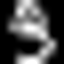
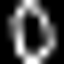
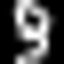
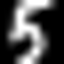
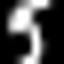
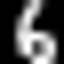
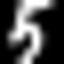
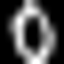
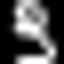
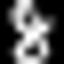
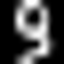
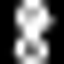
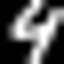
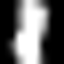
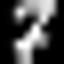
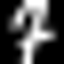
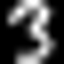
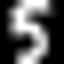
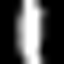
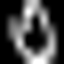
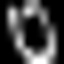
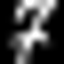
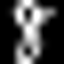
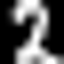
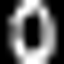
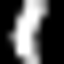
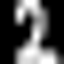
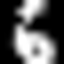
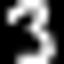
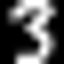
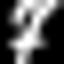
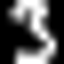
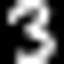
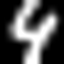
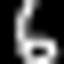
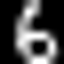
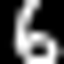
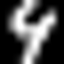
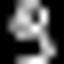
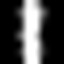
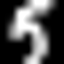
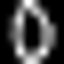
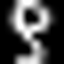
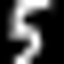
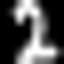
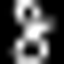
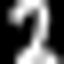
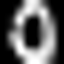
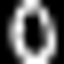
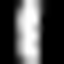
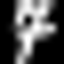
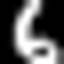
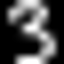
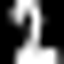
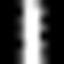
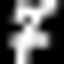
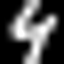
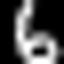
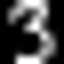
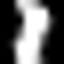
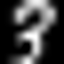
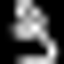
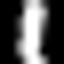
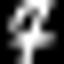
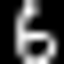
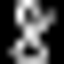
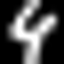
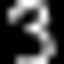
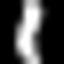
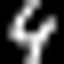
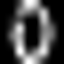
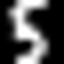
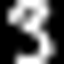
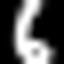
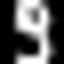
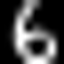
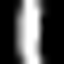
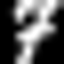
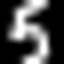
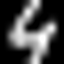
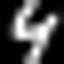
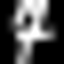
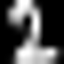
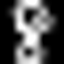
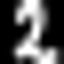
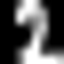
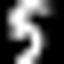
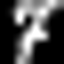
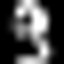
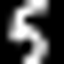
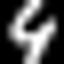
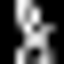
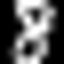
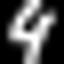
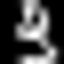
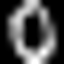
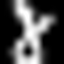
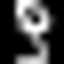
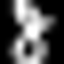
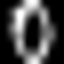
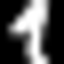
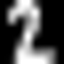
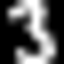
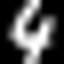
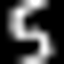
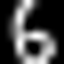
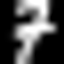
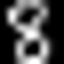
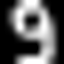
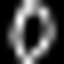
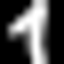
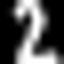
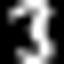
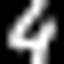
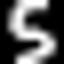
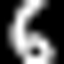
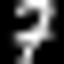
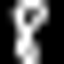
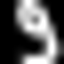
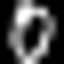
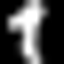
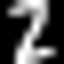
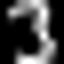
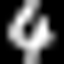
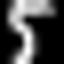
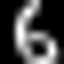
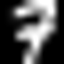
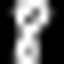
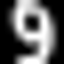
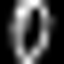
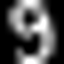
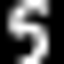
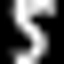
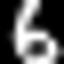
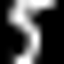
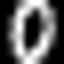
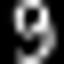
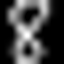
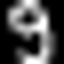
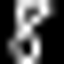
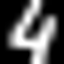
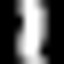
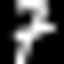
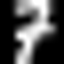
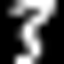
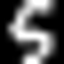
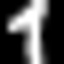
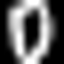
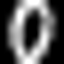
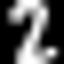
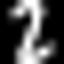
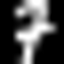
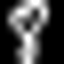
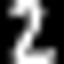
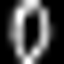
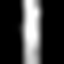
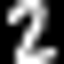
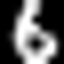
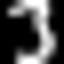
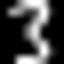
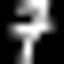
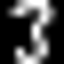
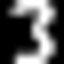
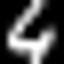
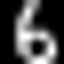
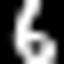
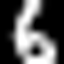
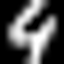
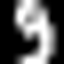
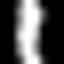
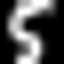
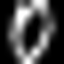
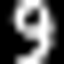
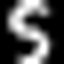
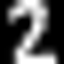
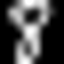
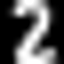
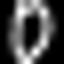
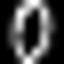
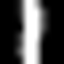
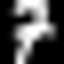
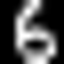
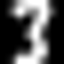
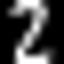
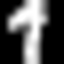
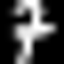
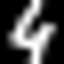
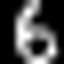
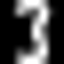
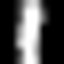
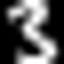
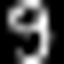
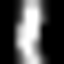
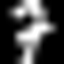
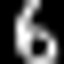
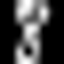
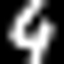
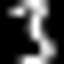
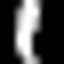
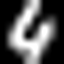
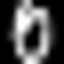
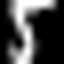
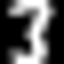
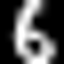
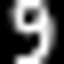
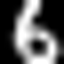
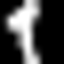
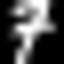
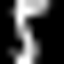
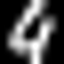
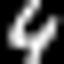
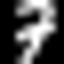
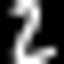
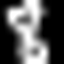
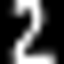
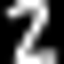
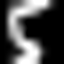
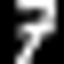
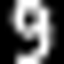
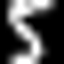
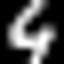
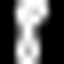
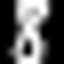
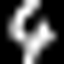
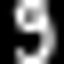
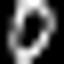
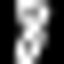
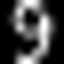
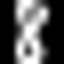
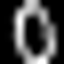
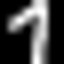
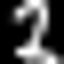
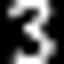
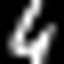
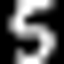
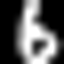
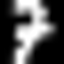
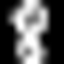
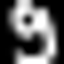
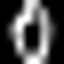
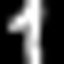
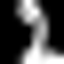
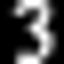
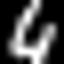
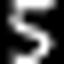
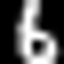
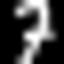
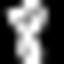
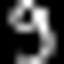
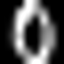
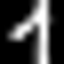
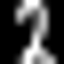
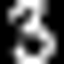
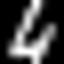
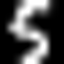
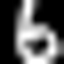
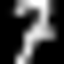
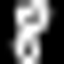
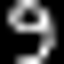
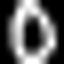
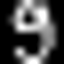
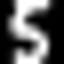
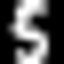
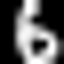
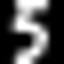
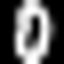
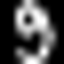
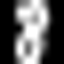
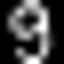
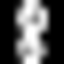
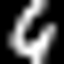
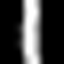
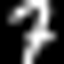
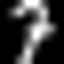
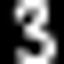
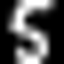
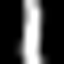
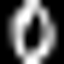
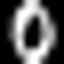
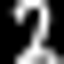
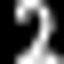
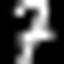
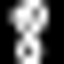
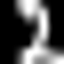
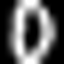
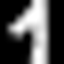
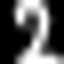
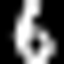
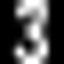
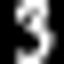
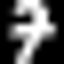
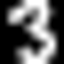
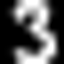
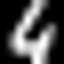
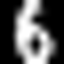
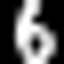
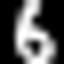
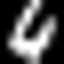
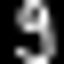
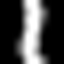
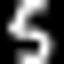
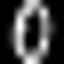
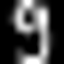
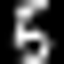
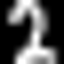
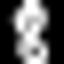
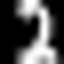
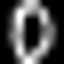
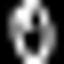
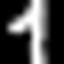
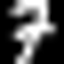
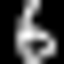
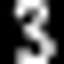
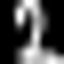
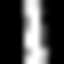
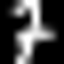
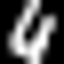
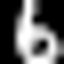
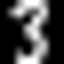
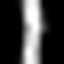
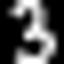
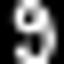
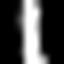
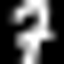
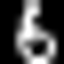
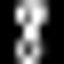
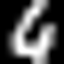
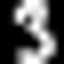
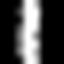
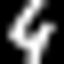
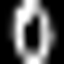
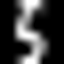
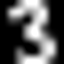
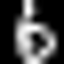
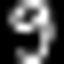
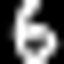
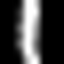
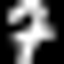
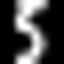
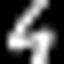
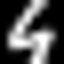
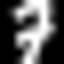
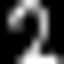
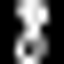
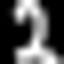
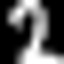
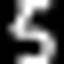
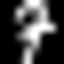
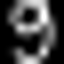
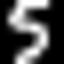
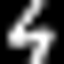
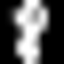
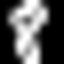
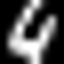
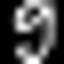
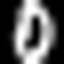
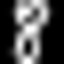
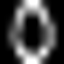
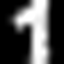
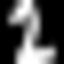
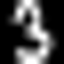
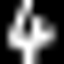
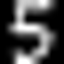
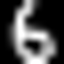
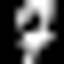
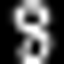
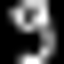
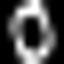
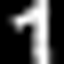
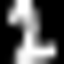
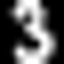
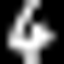
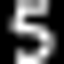
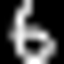
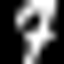
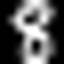
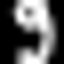
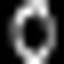
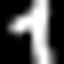
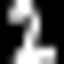
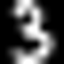
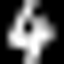
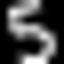
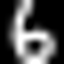
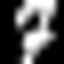
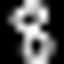
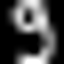
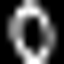
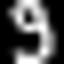
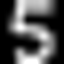
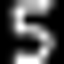
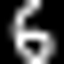
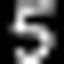
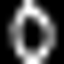
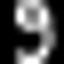
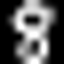
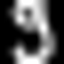
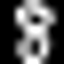
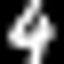
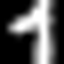
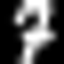
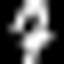
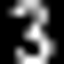
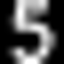
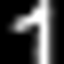
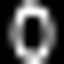
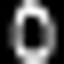
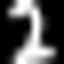
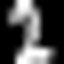
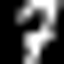
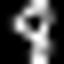
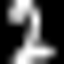
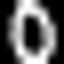
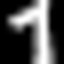
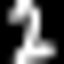
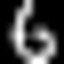
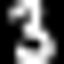
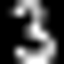
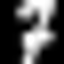
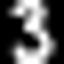
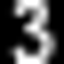
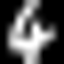
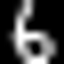
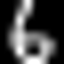
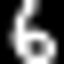
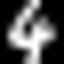
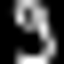
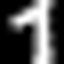
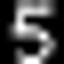
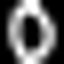
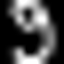
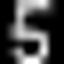
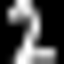
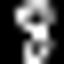
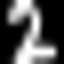
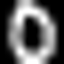
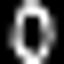
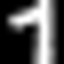
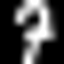
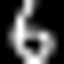
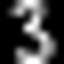
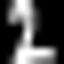
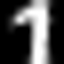
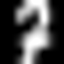
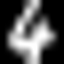
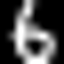
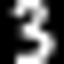
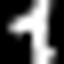
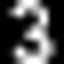
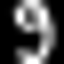
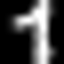
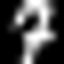
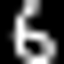
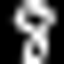
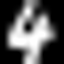
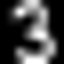
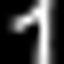
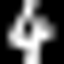
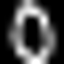
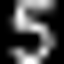
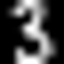
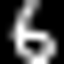
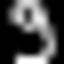
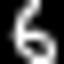
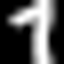
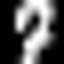
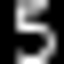
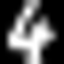
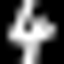
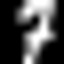
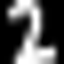
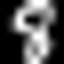
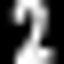
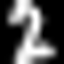
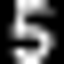
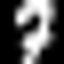
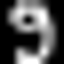
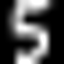
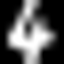
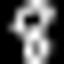
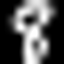
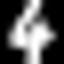
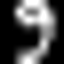
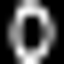
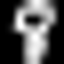
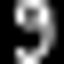
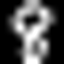
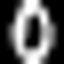
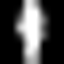
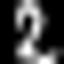
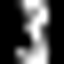
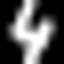
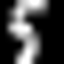
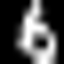
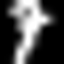
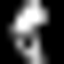
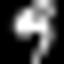
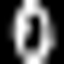
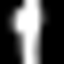
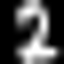
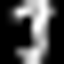
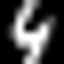
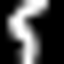
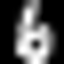
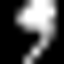
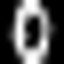
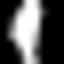
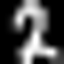
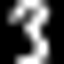
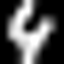
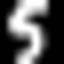
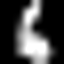
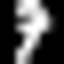
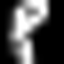
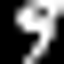
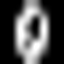
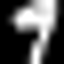
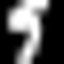
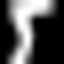
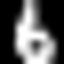
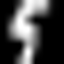
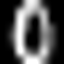
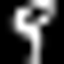
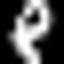
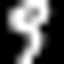
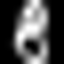
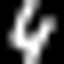
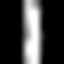
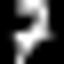
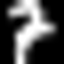
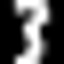
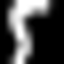
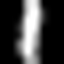
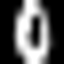
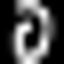
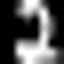
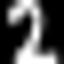
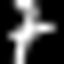
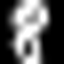
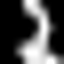
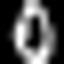
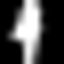
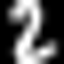
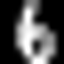
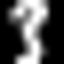
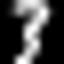
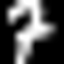
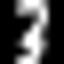
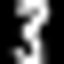
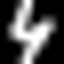
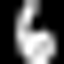
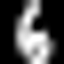
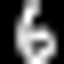
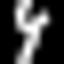
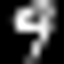
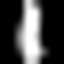
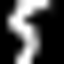
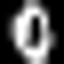
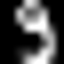
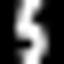
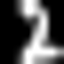
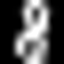
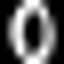
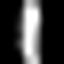
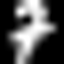
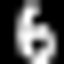
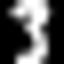
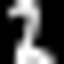
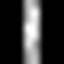
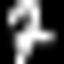
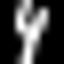
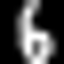
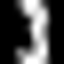
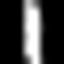
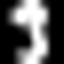
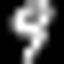
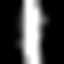
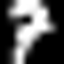
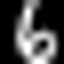
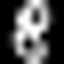
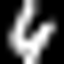
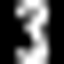
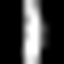
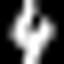
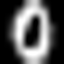
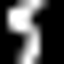
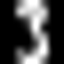
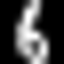
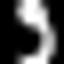
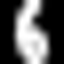
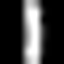
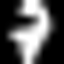
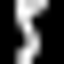
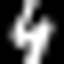
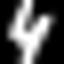
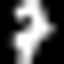
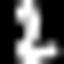
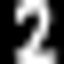
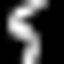
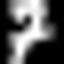
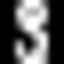
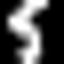
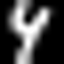
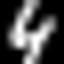
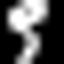
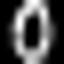
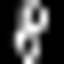
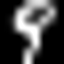
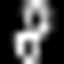
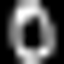
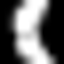
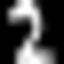
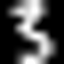
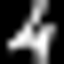
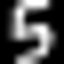
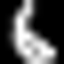
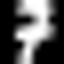
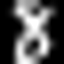
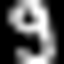
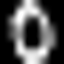
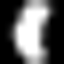
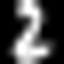
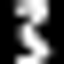
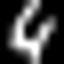
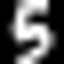
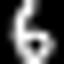
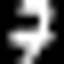
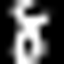
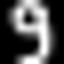
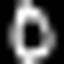
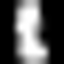
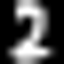
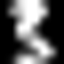
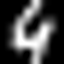
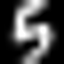
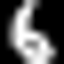
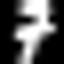
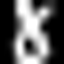
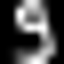
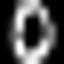
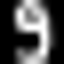
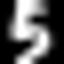
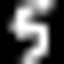
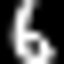
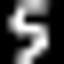
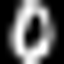
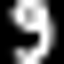
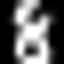
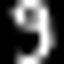
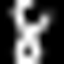
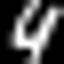
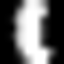
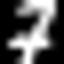
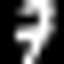
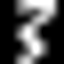
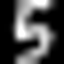
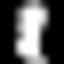
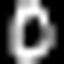
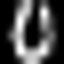
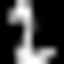
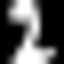
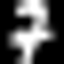
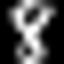
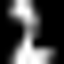
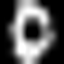
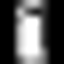
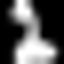
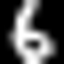
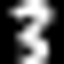
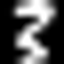
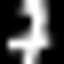
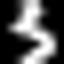
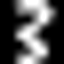
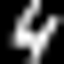
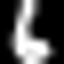
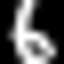
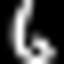
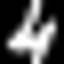
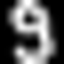
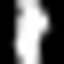
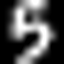
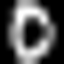
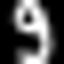
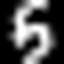
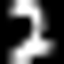
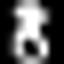
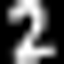
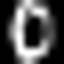
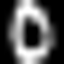
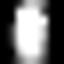
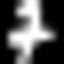
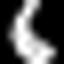
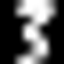
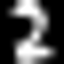
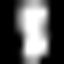
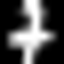
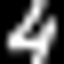
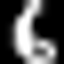
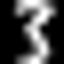
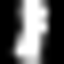
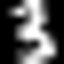
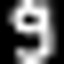
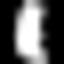
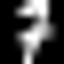
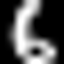
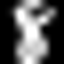
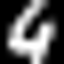
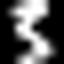
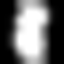
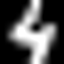
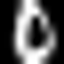
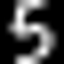
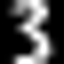
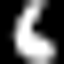
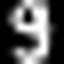
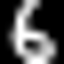
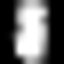
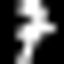
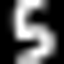
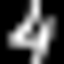
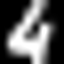
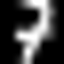
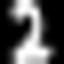
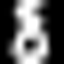
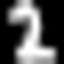
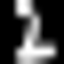
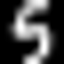
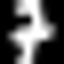
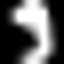
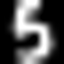
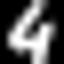
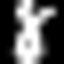
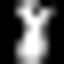
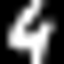
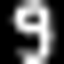
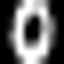
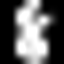
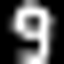
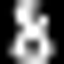

In [15]:
plot_datasource = ColumnDataSource(plot_dataframe)

color_mapping = CategoricalColorMapper(factors=np.unique(plot_dataframe.cluster).tolist(), 
                                       palette=['#777777'] + viridis(plot_dataframe.cluster.max() + 1))

plot_figure = figure(title='UMAP embedding of the MNIST digits data',
                     plot_width=600,
                     plot_height=600,
                     tools=('pan, wheel_zoom, box_zoom, resize, reset'),
                     active_scroll='wheel_zoom')

plot_figure.add_tools( HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: left; margin: 5px 5px 5px 5px'></img>
    </div>
    <div>
        <span style='font-size: 14px; color: #224499'>Target:</span>
        <span style='font-size: 16px'>@target</span>
    </div>
    <div>
        <span style='font-size: 14px; color: #224499'>Cluster id:</span>
        <span style='font-size: 16px'>@cluster</span>
    </div>
</div>
"""))

plot_figure.circle('x', 'y', source=plot_datasource, 
                   color=dict(field='cluster', transform=color_mapping), 
                   line_alpha=0.4, fill_alpha=0.4, size=4)

show(plot_figure)

Hopefully this gives some flavour of what can be achieved by UMAP and Bokeh! Consult the Bokeh cheat sheets or your friendyl data science support team for further details and customisation.